In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
!pip install spectral

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from tensorflow.keras.layers import Dropout, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from operator import truediv
from plotly.offline import init_notebook_mode
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
# import spectral
init_notebook_mode(connected=True)
%matplotlib inline

def splitTrainTestSet(X, y, testRatio, randomState=123):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=123,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

# maindata = '/content/gdrive/My Drive/indiana/SimDataPureMixed15minerals.mat'
# t = sio.loadmat(maindata)
# y = t['ref']
# Xp = t['HSimgPure']
# Xm = t['HSimgMixed']
# print('Xp',Xp.shape)
# print('Xm',Xm.shape)
# print(y.shape)
# print(np.unique(y))
# print(len(np.unique(y)))
# # X = Xm
# X = Xp
windowSize = 25
K =5
test_ratio = 0.7

# X,pca = applyPCA(X,numComponents=K)
# Xtest, ytest = createImageCubes(X, y, windowSize=windowSize)
# x_train, x_test, y_train, y_test = splitTrainTestSet(Xtest, ytest, test_ratio)

Xtrain = np.load('/content/gdrive/My Drive/indiana/Simulation/x_train_Simulation_test_ratio0.7windowSize25pca5.npy')
Xtest = np.load('/content/gdrive/My Drive/indiana/Simulation/y_train_Simulation_test_ratio0.7windowSize25pca5.npy')
ytrain = np.load('/content/gdrive/My Drive/indiana/Simulation/x_test_Simulation_test_ratio0.7windowSize25pca5.npy')
ytest = np.load('/content/gdrive/My Drive/indiana/Simulation/y_test_Simulation_test_ratio0.7windowSize25pca5.npy')

print(Xtrain.shape)
print(ytrain.shape)
print(Xtest.shape)
print(ytest.shape)
print(np.unique(ytest))
print(len(np.unique(ytest)))
print('end')

# ground_truth = spectral.imshow(y, figsize=(7, 7))
# plt.show()

(71180, 25, 25, 5)
(166087, 25, 25, 5)
(71180,)
(166087,)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
15
end


In [1]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
ytrain = np_utils.to_categorical(ytrain)
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
ytest = np_utils.to_categorical(ytest)

S = windowSize
L = K
input_layer = Input((S, S, L, 1))
output_units = 15

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
print(conv_layer3._shape)
conv3d_shape = conv_layer3._shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100)
model.save('/content/gdrive/My Drive/indiana/my_model.h5')

NameError: ignored

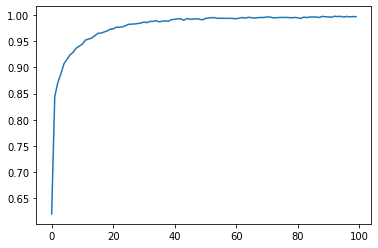

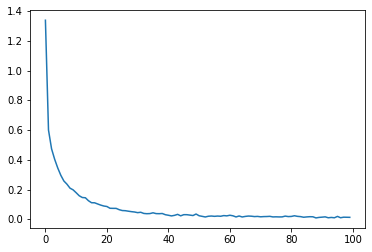

In [0]:
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train acc', 'val_accuracy'], loc='upper left')
plt.show()

plt.figure()
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val_loss'], loc='upper left')
plt.show()

In [0]:
model.load_weights('/content/gdrive/My Drive/indiana/my_model.h5')
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])


Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
ytest = np_utils.to_categorical(ytest)

import warnings
warnings.filterwarnings('always')

Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)


classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       0.92      0.97      0.95       198
           1       0.94      0.92      0.93       163
           2       0.83      0.87      0.84       126
           3       0.93      0.94      0.93       293
           4       0.97      0.91      0.94       355
           5       0.95      0.97      0.96       453
           6       0.95      0.92      0.93       101
           7       0.93      0.92      0.92       305
           8       0.71      0.75      0.73        16
           9       0.91      0.91      0.91       351
          10       0.95      0.92      0.93       320
          11       0.94      0.94      0.94        16
          12       0.88      0.92      0.90        39
          13       0.91      0.95      0.93       181
          14       0.92      0.96      0.94       216
          15       0.88      0.91      0.89       182
          16       0.98      0.86      0.92       143
          17       0.94    

In [0]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc


def reports (X_test,y_test,name):
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    target_names = ['1', '2', '3', '4','5', '6', '7', '8', '9', '10', '11','12', '13', '14', '15','16','17','18','19','20']
                        
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "/content/gdrive/My Drive/indiana/classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))


def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

133/133 [==============================] - 1s 6ms/step - loss: 0.4657 - accuracy: 0.9272


In [0]:
maindata = '/content/gdrive/My Drive/indiana/Data_Simulation_20minerals.mat'
t = sio.loadmat(maindata)
y = t['ref']
X = t['HSimg']
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K
X,pca = applyPCA(X, numComponents=numComponents)
X = padWithZeros(X, PATCH_SIZE//2)

# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

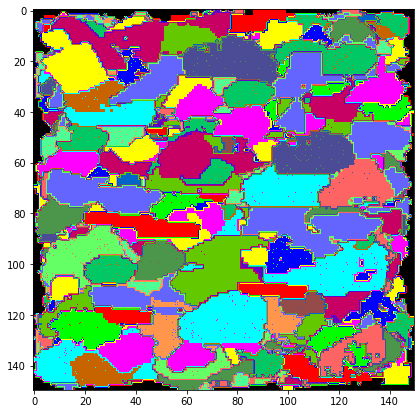

In [0]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))


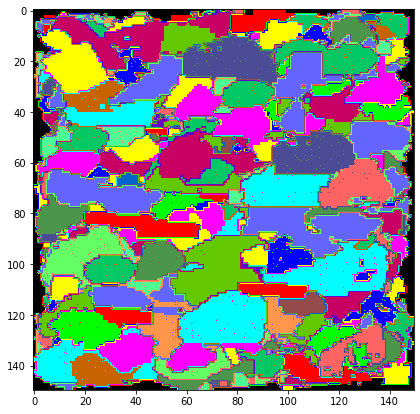

In [0]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))
